In [51]:
import pandas as pd
import dask
dask.config.set(scheduler="processes")
import matplotlib.pyplot as plt
import numpy as np

In [11]:
pd.read_csv("./Data/bbo/MSFT.A/2010-07-21-MSFT.A-bbo.csv.gz",compression="gzip")

,xltime,bid-price,bid-volume,ask-price,ask-volume
0,40380.562525,25.23,1,25.73,1
1,40380.562560,25.23,2,25.73,1
2,40380.562583,25.24,1,25.73,1
3,40380.562594,25.26,1,25.73,1
4,40380.563231,25.26,1,25.60,1
...,...,...,...,...,...
45089,40380.833334,24.84,1,25.12,4
45090,40380.833334,24.84,1,25.12,9
45091,40380.836823,24.84,1,25.12,1
45092,40380.855605,24.84,1,27.39,1


In [68]:
d1 = pd.read_csv("./Data/trade/MSFT.A/2010-07-21-MSFT.A-trade.csv.gz",compression="gzip")
d2 = pd.read_csv("./Data/trade/MSFT.B/2010-07-21-MSFT.B-trade.csv.gz",compression="gzip")

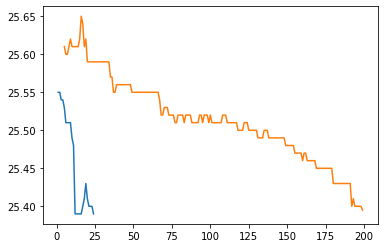

In [69]:
def convert_time(df):
    df["xltime"] = pd.to_datetime(df["xltime"],unit="d",origin="1899-12-30",utc=True)
    return df

d1 = convert_time(d1)
d2 = convert_time(d2)
plt.plot(d1["trade-price"][1:25])
plt.plot(d2["trade-price"][5:200])

In [60]:
j = d2.join(d1,lsuffix='_l', rsuffix='_r')
j[j["xltime_r"].fillna(-1) > 0]

,xltime_l,trade-price_l,trade-volume_l,trade-stringflag_l,trade-rawflag_l,xltime_r,trade-price_r,trade-volume_r,trade-stringflag_r,trade-rawflag_r
xltime,,,,,,,,,,
2010-07-21 13:35:01.865961600+00:00,40380.565994,25.39,500,uncategorized,[GV1_TEXT ]@ ...,40380.565994,25.39,200.0,uncategorized,[GV1_TEXT ]@F ...
2010-07-21 13:36:07.085001600+00:00,40380.566749,25.43,200,uncategorized,[GV1_TEXT ]@F ...,40380.566749,25.43,100.0,uncategorized,[GV1_TEXT ]@F ...
2010-07-21 13:38:42.375004800+00:00,40380.568546,25.37,100,uncategorized,[GV1_TEXT ]@F ...,40380.568546,25.36,100.0,uncategorized,[GV1_TEXT ]@F ...
2010-07-21 13:39:28.853020800+00:00,40380.569084,25.30,100,uncategorized,[GV1_TEXT ]@ ...,40380.569084,25.30,100.0,uncategorized,[GV1_TEXT ]@ ...
2010-07-21 13:39:29.367964799+00:00,40380.569090,25.31,100,uncategorized,[GV1_TEXT ]@F ...,40380.569090,25.30,100.0,uncategorized,[GV1_TEXT ]@F ...
...,...,...,...,...,...,...,...,...,...,...
2010-07-21 19:50:01.264041600+00:00,40380.826404,25.03,100,uncategorized,[GV1_TEXT ]@ ...,40380.826404,25.04,100.0,uncategorized,[GV1_TEXT ]@F ...
2010-07-21 19:50:01.264041600+00:00,40380.826404,25.03,100,uncategorized,[GV1_TEXT ]@ ...,40380.826404,25.04,100.0,uncategorized,[GV1_TEXT ]@F ...
2010-07-21 19:50:01.264041600+00:00,40380.826404,25.03,100,uncategorized,[GV1_TEXT ]@ ...,40380.826404,25.04,100.0,uncategorized,[GV1_TEXT ]@F ...


In [81]:
tolerance = 5
pd.merge_asof(d2,d1,on="xltime",tolerance=pd.Timedelta(f"{tolerance}s")).dropna()

,xltime,trade-price_x,trade-volume_x,trade-stringflag_x,trade-rawflag_x,trade-price_y,trade-volume_y,trade-stringflag_y,trade-rawflag_y
65,2010-07-21 13:31:52.353004800+00:00,25.55,100,uncategorized,[GV1_TEXT ]@ ...,25.55,100.0,uncategorized,[GV1_TEXT ]@F ...
67,2010-07-21 13:32:01.261968+00:00,25.54,100,uncategorized,[GV1_TEXT ]@F ...,25.55,100.0,uncategorized,[GV1_TEXT ]@F ...
68,2010-07-21 13:32:06.319996800+00:00,25.52,100,uncategorized,[GV1_TEXT ]@ ...,25.54,300.0,uncategorized,[GV1_TEXT ]@F ...
73,2010-07-21 13:32:13.261977599+00:00,25.52,100,uncategorized,[GV1_TEXT ]@F ...,25.53,400.0,uncategorized,[GV1_TEXT ]@F ...
74,2010-07-21 13:32:13.528003200+00:00,25.52,100,uncategorized,[GV1_TEXT ]@F ...,25.53,400.0,uncategorized,[GV1_TEXT ]@F ...
...,...,...,...,...,...,...,...,...,...
18319,2010-07-21 19:57:46.159977600+00:00,25.08,100,uncategorized,[GV1_TEXT ]@ ...,25.07,1200.0,uncategorized,[GV1_TEXT ]@F ...
18354,2010-07-21 19:58:21.158025600+00:00,25.04,400,uncategorized,[GV1_TEXT ]@F ...,25.04,100.0,uncategorized,[GV1_TEXT ]@ ...
18355,2010-07-21 19:58:21.479001600+00:00,25.04,700,uncategorized,[GV1_TEXT ]@F ...,25.04,100.0,uncategorized,[GV1_TEXT ]@ ...
18356,2010-07-21 19:58:21.869961600+00:00,25.04,200,uncategorized,[GV1_TEXT ]@ ...,25.04,100.0,uncategorized,[GV1_TEXT ]@ ...
